# Get the Data

**Why this section?** Before building any ML model, we need data. This chapter uses the California Housing dataset - a classic regression problem where we predict median house values based on features like location, population, and income.

**Why this code?** We create a function to download and load the housing dataset. It:
1. Downloads the compressed data from GitHub if not already present
2. Extracts the CSV file from the tarball
3. Returns it as a pandas DataFrame

This pattern (checking if file exists first) avoids re-downloading every time we run the notebook.

In [213]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

**Why `.head()`?** This shows the first 5 rows of data. It's the first thing you should do with any dataset to:
- See what columns exist
- Understand the data types (numbers, text, etc.)
- Get a feel for the values (ranges, patterns)

In [214]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Why `.info()`?** This gives us metadata about the DataFrame:
- Total number of rows (20,640 districts)
- Column names and their data types
- **Non-null counts** - CRITICAL! Notice `total_bedrooms` has only 20,433 non-null values (207 missing). We'll need to handle these missing values later.

In [215]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Why `.value_counts()` on `ocean_proximity`?** This is a categorical feature (text, not numbers). We need to understand:
- What categories exist (5 total: <1H OCEAN, INLAND, NEAR OCEAN, NEAR BAY, ISLAND)
- How many samples in each category
- Notice ISLAND has only 5 samples - very imbalanced! This could affect our model.

In [216]:
housing_full["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

**Why `.describe()`?** This shows summary statistics for all numerical columns:
- `count`: number of non-null values
- `mean`, `std`: average and spread
- `min`, `25%`, `50%`, `75%`, `max`: distribution of values

**Key insights:**
- `median_house_value` max is 500,001 (capped!) - this is a problem, many values might be truncated
- `housing_median_age` max is 52 (also capped)
- Features have very different scales (median_income ~3.9 vs total_rooms ~2635)

In [217]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Why plot histograms?** Visualizing the distribution of each feature helps us understand:
- Are values normally distributed or skewed?
- Are there outliers?
- Do we need to transform features? (many are tail-heavy/skewed → might benefit from log transform)

**Key observations:**
- `median_income` is scaled (expressed in tens of thousands of dollars)
- `housing_median_age` and `median_house_value` are capped (vertical bars at max values)
- Many features are skewed right (long tail on right side)

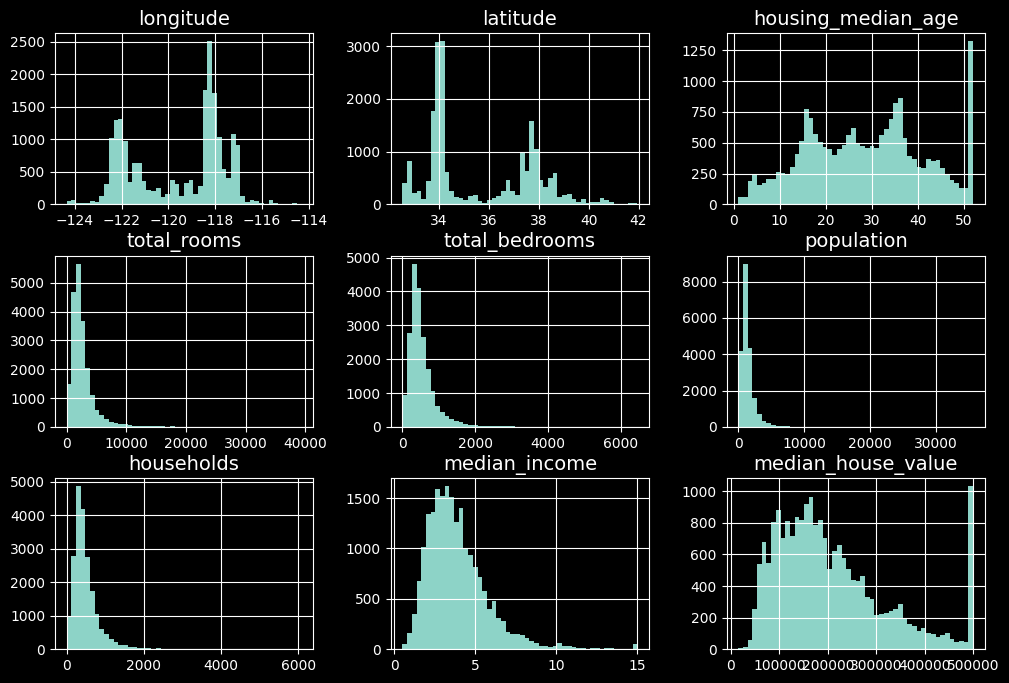

In [218]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing_full.hist(bins=50, figsize=(12, 8))

plt.show()

## Train/Test Split

**Why split the data?** This is FUNDAMENTAL to ML:
- **Training set (80%)**: Used to train/fit the model
- **Test set (20%)**: Kept completely separate to evaluate how well the model generalizes to unseen data

If we evaluate on training data, we'd get overly optimistic results (the model "memorized" the data).

In [219]:
import numpy as np

def shuffle_and_split_data(data, test_ratio, rng):
    shuffled_indices = rng.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

**Why use `seed=42`?** Setting a random seed makes the split reproducible. Every time you run with seed=42, you get the exact same split. This is essential for:
- Debugging (consistent results)
- Sharing work (others can reproduce your results)
- Comparing models fairly (same train/test data)

In [220]:
rng = np.random.default_rng(seed=42)
train_set, test_set = shuffle_and_split_data(housing_full, 0.2, rng)
len(train_set)

16512

In [221]:
len(test_set)

4128

**Why hash-based splitting?** The previous method has a problem: if you get new data and re-run, the split changes! Some previous test samples might end up in training.

**Solution**: Use a stable identifier (hash of row ID) to decide train/test. The same row will ALWAYS go to the same set, even when new data is added. This prevents "data snooping" - accidentally training on test data.

In [222]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [223]:
housing_with_id = housing_full.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

**Why use longitude + latitude as ID?** The row index isn't a great identifier - if rows get reordered or deleted, indices change. Using `longitude * 1000 + latitude` creates a unique identifier based on the district's location, which won't change.

In [224]:
housing_with_id["id"] = (housing_full["longitude"] * 1000
                         + housing_full["latitude"])
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

**Why use sklearn's `train_test_split`?** In practice, just use this! It:
- Handles shuffling and splitting in one line
- Supports stratification (see below)
- Is well-tested and optimized

The previous manual implementations were for educational purposes to understand what's happening under the hood.

In [225]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_full, test_size=0.2,
                                       random_state=42)

In [226]:
test_set["total_bedrooms"].isnull().sum()

np.int64(44)

## Stratified Sampling

**The Problem:** Random sampling might give us a test set that doesn't represent the full population. For example, if income strongly affects house prices, our test set should have the same income distribution as the overall data.

**Why create income categories?** We'll use these to ensure both train and test sets have the same proportion of low/medium/high income districts.

In [227]:
housing_full["income_cat"] = pd.cut(housing_full["median_income"],
                                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

**Why `pd.cut()`?** This bins continuous income values into discrete categories:
- Category 1: income 0-1.5 (lowest)
- Category 2: income 1.5-3.0
- Category 3: income 3.0-4.5
- Category 4: income 4.5-6.0
- Category 5: income 6.0+ (highest)

We chose 5 bins so each has enough samples for meaningful stratification.

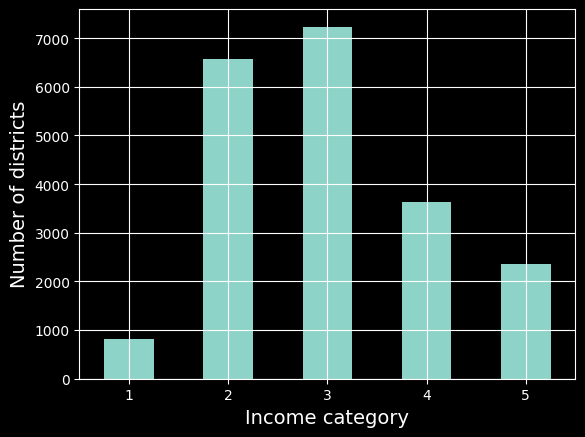

In [228]:
cat_counts = housing_full["income_cat"].value_counts().sort_index()
cat_counts.plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")

plt.show()

**Why `StratifiedShuffleSplit`?** This performs stratified sampling - it ensures the test set has the same proportion of each income category as the full dataset.

Example: If 35% of all districts are in income category 3, then ~35% of the test set will also be in category 3. This gives us a representative test set.

In [229]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_full,
                                              housing_full["income_cat"]):
    strat_train_set_n = housing_full.iloc[train_index]
    strat_test_set_n = housing_full.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [230]:
strat_train_set, strat_test_set = strat_splits[0]

In [231]:
strat_train_set, strat_test_set = train_test_split(
    housing_full, test_size=0.2, stratify=housing_full["income_cat"],
    random_state=42)

**Simpler way:** Just use `stratify` parameter in `train_test_split()`. Same result, less code!

In [232]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

**Verifying stratification worked:** The proportions in the test set should closely match the overall dataset. Compare "Stratified %" vs "Random %" in the comparison table below - stratified sampling has much lower error!

In [233]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_full, test_size=0.2,
                                       random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing_full),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [234]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

**Why drop `income_cat`?** We only created this column for stratified sampling. Now that we have our train/test split, we remove it so it doesn't interfere with our model (it's derived from `median_income`, so it would be redundant/leaking information).

In [235]:
housing = strat_train_set.copy()

## Visualize the Data to Gain Insights

**Why `.copy()`?** We make a copy of the training set to explore and modify without affecting the original. This is a good habit - always preserve your original data.

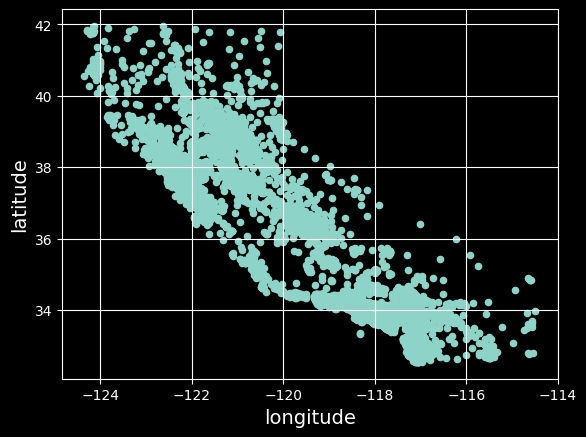

In [236]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)

plt.show()

**Why plot latitude vs longitude?** This creates a geographical scatter plot showing California's shape. It's a sanity check - if the data looks like California, we know the coordinates make sense!

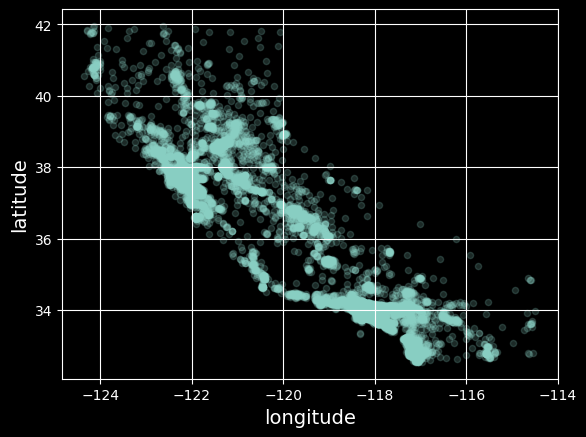

In [237]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

plt.show()

**Why `alpha=0.2`?** With thousands of points, they overlap and hide density patterns. Setting alpha (transparency) to 0.2 means overlapping points become darker, revealing high-density areas (like the Bay Area and LA).

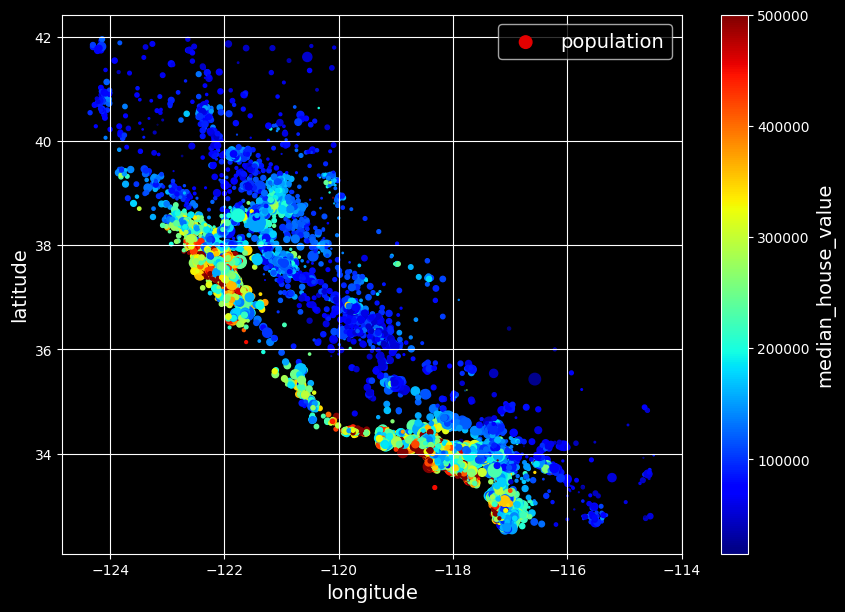

In [238]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
            s=housing["population"] / 100, label="population",
            c="median_house_value", cmap="jet", colorbar=True,
            legend=True, sharex=False, figsize=(10, 7))

plt.show()

**Why add color and size encoding?** This visualization packs 4 dimensions into 2D:
- **x-axis**: longitude (location)
- **y-axis**: latitude (location)
- **Circle size (s)**: population (bigger = more people)
- **Circle color (c)**: median_house_value (red = expensive, blue = cheap)

**Key insight**: Expensive houses (red) cluster near the coast (ocean proximity matters!) and in urban areas.

In [239]:
corr_matrix = housing.corr(numeric_only=True)

## Looking for Correlations

**Why compute correlations?** The correlation coefficient (ranging from -1 to +1) measures linear relationships:
- **+1**: Perfect positive correlation (when one goes up, the other goes up)
- **-1**: Perfect negative correlation (when one goes up, the other goes down)
- **0**: No linear relationship

This helps identify which features might be useful for predicting house values.

In [240]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

**Key insight:** `median_income` has the strongest correlation (0.69) with `median_house_value`. This makes intuitive sense - wealthier areas have more expensive houses. Other features have weak correlations.

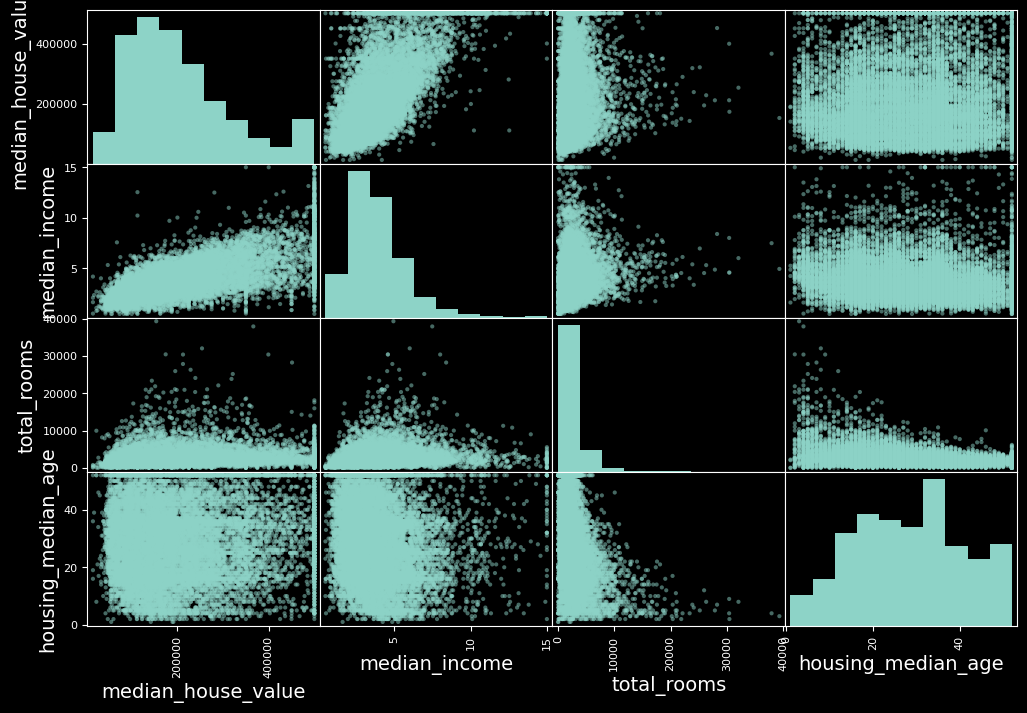

In [241]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

plt.show()

**Why use `scatter_matrix`?** This plots every attribute against every other attribute, helping visualize relationships. The diagonal shows histograms of each feature. We pick the 4 most promising features to keep the plot readable.

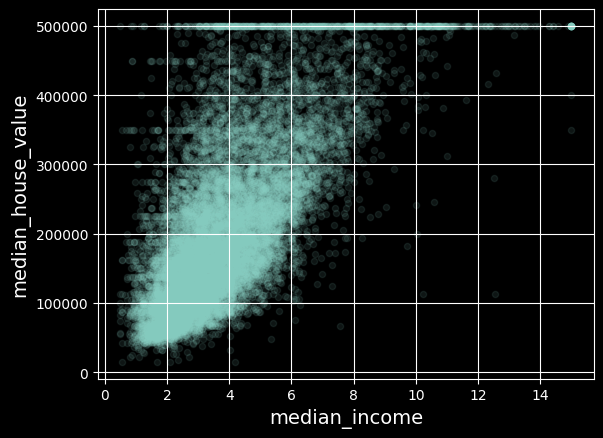

In [242]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)

plt.show()

**Zooming in on the best correlation:** The income vs house value plot shows:
- Clear upward trend (correlation works!)
- A horizontal line at $500k (the cap we noticed earlier)
- Some horizontal lines around $450k, $350k, etc. (data quirks to investigate)

In [243]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

## Feature Engineering (Experimenting with Attribute Combinations)

**Why create new features?** Raw features might not capture useful patterns. By combining existing features, we can create more meaningful ones:
- `rooms_per_house`: average rooms per household (bigger houses might be more expensive)
- `bedrooms_ratio`: fraction of rooms that are bedrooms (houses with more living space vs bedrooms)
- `people_per_house`: how crowded households are

In [244]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

**Did our new features help?** Check the correlations:
- `bedrooms_ratio` has -0.26 correlation (negative! more bedrooms relative to total rooms = cheaper houses)
- `rooms_per_house` has 0.14 correlation (slightly better than raw room counts)

Feature engineering can significantly improve model performance!

In [245]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Prepare the Data for Machine Learning

**Why separate features from labels?** Most ML algorithms expect:
- **X (features)**: The input data used to make predictions
- **y (labels/targets)**: What we're trying to predict (`median_house_value`)

We drop the target column from features to prevent "data leakage" - the model shouldn't have access to the answer when learning!

In [246]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


## Handling Missing Values

**The Problem:** `total_bedrooms` has missing values (NaN). Most ML algorithms can't handle NaN - they'll crash or give wrong results. Let's see which rows have missing data.

In [247]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


**Three options to handle missing values:**

**Option 1: Drop rows with missing values** (`dropna`)
- Pros: Simple, no fake data
- Cons: Lose training data (bad if you have few samples)

In [248]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


**Option 2: Drop the entire column** (`drop`)
- Pros: Simple, no fake data
- Cons: Lose a potentially useful feature

In [249]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"] = housing_option3["total_bedrooms"].fillna(median)  # option 3

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


**Option 3: Fill missing values with a statistic** (imputation)
- Use median (robust to outliers), mean, or most frequent value
- Pros: Keep all data
- Cons: Introduces artificial values

**Median is usually best** - it's not affected by extreme outliers like mean would be.

In [250]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

**Why use `SimpleImputer` from sklearn?** Instead of manually computing medians, sklearn's `SimpleImputer`:
- Computes the statistic during `fit()` (learning the median from training data)
- Applies it during `transform()` (filling missing values)
- Can be saved and reused on new data (crucial for production!)
- Works on ALL numeric columns at once

In [251]:
housing_num = housing.select_dtypes(include=[np.number])

**Why select only numeric columns?** The imputer computes medians, which only makes sense for numbers. We exclude `ocean_proximity` (a text/categorical column) - we'll handle it separately later.

In [252]:
imputer.fit(housing_num)

,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False


**The fit-transform pattern:** This is FUNDAMENTAL to sklearn:
1. **`fit(X)`**: Learn parameters from training data (here: compute medians)
2. **`transform(X)`**: Apply the learned transformation

Why separate? So we can apply the SAME transformation (same medians) to new test data later!

In [253]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

**What did the imputer learn?** The `statistics_` attribute stores the computed medians for each column. These are the values that will replace NaNs.

In [254]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [255]:
X = imputer.transform(housing_num)

**Why `transform()` returns a NumPy array?** sklearn transformers return plain NumPy arrays by default. We often convert back to DataFrame (as shown below) to keep column names and indices.

In [256]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [257]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [258]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [259]:
imputer.strategy

'median'

In [260]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [261]:
housing_tr.loc[null_rows_idx].head()  # not shown in the book

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [262]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

**Why use `IsolationForest` for outlier detection?** Outliers can hurt model performance. `IsolationForest` is an unsupervised algorithm that identifies unusual data points by how easily they can be "isolated" from the rest. This is optional but useful for data quality.

In [263]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


## Handling Categorical Features

**The Problem:** `ocean_proximity` contains text categories like "NEAR BAY", "INLAND", etc. ML algorithms need numbers, not text. How do we convert categories to numbers?

In [264]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

**Option 1: Ordinal Encoding** - Assign each category a number (0, 1, 2, 3, 4)

**Problem:** This implies an ordering (INLAND=1 > <1H OCEAN=0), but ocean proximity categories have no natural order! The model might incorrectly assume INLAND is "greater than" NEAR BAY.

In [265]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [266]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

**Option 2: One-Hot Encoding** (BETTER for unordered categories!)

Creates a binary column for each category:
- `ocean_proximity_<1H OCEAN`: 1 if <1H OCEAN, 0 otherwise
- `ocean_proximity_INLAND`: 1 if INLAND, 0 otherwise
- etc.

This way, no false ordering is implied. Only one column will be "hot" (=1) for each row.

In [267]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

**Why sparse matrix?** By default, OneHotEncoder returns a sparse matrix - it only stores the positions of 1s (not all the 0s). This saves memory when you have many categories. Use `.toarray()` to see the full dense matrix.

In [268]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [269]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [270]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


**Pandas `get_dummies()` vs sklearn `OneHotEncoder`:**
- `get_dummies()` is simpler but doesn't remember categories from training data
- `OneHotEncoder` remembers categories and handles unknown values in new data
- **Use `OneHotEncoder` for ML pipelines** - it's more robust for production

In [271]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [272]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


**Handling unknown categories:** What if test data has a category not seen during training (e.g., "<2H OCEAN")? 
- `get_dummies()` creates a new column (breaks your model!)
- `OneHotEncoder` with `handle_unknown="ignore"` sets all columns to 0 (safer)

In [273]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [274]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [275]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [276]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [277]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

## Feature Scaling

**Why scale features?** Many ML algorithms (especially gradient descent-based ones) perform poorly when features have very different scales:
- `total_rooms`: ranges from 2 to 39,320
- `median_income`: ranges from 0.5 to 15

Without scaling, the algorithm might give more importance to features with larger values.

**MinMaxScaler (Normalization):** Scales values to a fixed range (default 0-1, or custom like -1 to 1). 
Formula: `(x - min) / (max - min)`

In [278]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

**StandardScaler (Standardization):** Transforms values to have mean=0 and std=1.
Formula: `(x - mean) / std`

**Which to use?**
- StandardScaler is usually preferred (less affected by outliers)
- MinMaxScaler when you need values in a specific range (e.g., neural network inputs often expect 0-1)

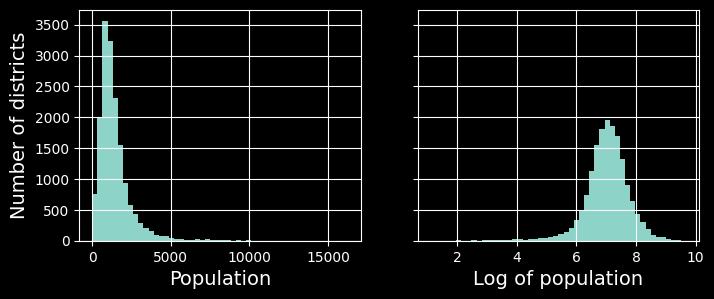

In [279]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

**Log Transformation for skewed data:** Remember how `population` was heavily skewed (long right tail)? Log transform compresses the tail and spreads out smaller values, making the distribution more Gaussian-like. Many ML algorithms work better with normally distributed data.

In [280]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

**RBF Kernel - Similarity Features:** The Radial Basis Function computes how "similar" each value is to a reference point. Here, we measure similarity to age=35. Houses with age near 35 get values close to 1, houses with very different ages get values close to 0. This can capture non-linear relationships!

In [281]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

**Scaling the Target Variable:** Sometimes you want to scale the labels too (e.g., so the model predicts in a standardized range). But remember to inverse-transform predictions back to the original scale!

In [282]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [283]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

**`TransformedTargetRegressor` - The Easy Way:** This wrapper handles target scaling automatically - it scales before training and inverse-transforms predictions. No manual inverse_transform needed!

In [284]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

**`FunctionTransformer` - Custom Transformations:** Wraps any function into a sklearn transformer. Here we wrap `np.log` so it can be used in pipelines. The `inverse_func` is needed if you ever want to reverse the transformation.

In [285]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [286]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [287]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [288]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

## Custom Transformers

**Why write custom transformers?** Sometimes you need transformations that don't exist in sklearn. By following sklearn's API (inherit from `BaseEstimator` and `TransformerMixin`, implement `fit()` and `transform()`), your custom transformer will work seamlessly in pipelines.

This example recreates `StandardScaler` from scratch to show the pattern.

In [289]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

**ClusterSimilarity - A Powerful Custom Transformer:**
This clever transformer:
1. Uses KMeans to find cluster centers (e.g., 10 "typical" locations in California)
2. For each district, computes similarity (RBF kernel) to each cluster center
3. Returns 10 new features representing "how similar is this district to each cluster"

This captures geographic patterns without hand-engineering location features!

In [290]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])

In [291]:
similarities[:3].round(2)

array([[0.46, 0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.  ],
       [0.  , 0.96, 0.  , 0.03, 0.04, 0.  , 0.  , 0.  , 0.11, 0.35],
       [0.34, 0.  , 0.45, 0.  , 0.  , 0.  , 0.01, 0.73, 0.  , 0.  ]])

In [292]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

## Transformation Pipelines

**Why use Pipelines?** Data preprocessing involves many steps (impute → scale → encode, etc.). Pipelines:
1. **Chain transformers** - execute them in sequence
2. **Prevent data leakage** - fit only on training data
3. **Simplify code** - one object to fit, transform, and save
4. **Enable cross-validation** - the whole pipeline is treated as one estimator

In [293]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

**`make_pipeline` - Shortcut:** Same as `Pipeline` but auto-generates step names from class names (lowercase). Less typing, same result.

In [294]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [295]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns =num_pipeline.get_feature_names_out(),
    index = housing_num.index
)

In [296]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "population", 'total_rooms', "median_income", 'households', "total_bedrooms"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs )
    ])

## ColumnTransformer - Different Pipelines for Different Columns

**The Problem:** We need different preprocessing for different column types:
- Numeric columns: impute missing values → scale
- Categorical columns: impute → one-hot encode

**ColumnTransformer** applies different transformers to different columns, then concatenates the results. This is the key to handling mixed data types!

In [297]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)


**`make_column_selector` - Auto-select Columns by Type:** Instead of listing column names manually, select columns by their dtype. This makes the pipeline more robust - if you add a new numeric column, it's automatically processed!

In [298]:
housing_prepared = preprocessing.fit_transform(housing)

In [299]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

## The Full Preprocessing Pipeline

**Putting it all together:** This comprehensive pipeline:
1. **bedrooms, rooms_per_house, people_per_house**: Create ratio features
2. **log**: Log-transform skewed features (bedrooms, rooms, population, etc.)
3. **geo**: Use ClusterSimilarity on lat/long to capture geographic patterns
4. **cat**: One-hot encode ocean_proximity
5. **remainder**: StandardScaler for remaining features (housing_median_age)

This is a production-ready preprocessing pipeline!

In [300]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

**Result:** Our pipeline transforms the original 9 features into 24 engineered features, ready for any ML algorithm. The `get_feature_names_out()` method shows what each column represents.

In [301]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [302]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('linearregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",Pipeline(step...ardScaler())])
,"sparse_threshold sparse_threshold: fl

## Select and Train a Model

**Why start with Linear Regression?** It's the simplest model - a good baseline. If a simple model works well, you might not need anything more complex. If it doesn't, you know the problem requires more sophistication.

**Notice:** We combine preprocessing + model into ONE pipeline. This is best practice - ensures the same preprocessing is always applied.

In [303]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([246000., 372700., 135700.,  91400., 330900.])

**Testing predictions:** Let's see how our model's predictions compare to actual values. The `-2` in `round(-2)` rounds to the nearest hundred for readability.

In [304]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

**Comparing predictions vs actual:** Look at the differences - the model predicts $246k but actual is $458k! That's a big error. We need a way to measure overall performance.

In [305]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68972.88910758478

**RMSE (Root Mean Squared Error):** The standard metric for regression:
1. Compute error for each prediction: `(predicted - actual)`
2. Square each error (so negatives don't cancel positives)
3. Take the mean of squared errors
4. Take the square root (to get back to original units: dollars)

**Result: ~$69,000 RMSE** - on average, predictions are off by $69k. That's bad! (Median house value is ~$180k)

In [306]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",Pipeline(step...ardScaler())])
,"sparse_threshold sparse_threshol

**Trying a more complex model: Decision Tree**

Linear Regression assumes a linear relationship, but housing prices likely have non-linear patterns. Decision Trees can capture complex, non-linear relationships by learning decision rules from the data.

In [307]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

**RMSE = 0?! That's suspicious!**

A perfect score on training data is a RED FLAG. The model has **overfit** - it memorized the training data perfectly but probably won't generalize to new data.

Think of it like a student who memorized all exam answers but doesn't understand the concepts - they'll fail on new questions.

In [308]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)

## Cross-Validation: Better Evaluation

**The Problem:** We can't use the test set yet (must save it for final evaluation). But evaluating on training data gives misleading results (overfitting).

**Solution: K-Fold Cross-Validation**
1. Split training data into K "folds" (here K=10)
2. Train on 9 folds, evaluate on the 1 held-out fold
3. Repeat 10 times, each time holding out a different fold
4. Average the 10 scores

This gives a reliable estimate of how the model will perform on unseen data!

**Note:** sklearn returns *negative* RMSE (because it maximizes scores), so we negate it.

In [309]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67013.360949
std       1460.198570
min      64289.376198
25%      66776.146282
50%      67086.216281
75%      68140.275029
max      68659.294290
dtype: float64

**Cross-validation results:** Mean RMSE ~$67k with std ~$1.5k. 

**Key insight:** Despite getting 0 RMSE on training data, the Decision Tree actually performs WORSE than Linear Regression on held-out data! This confirms severe overfitting. The tree memorized training data instead of learning generalizable patterns.

In [310]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                 scoring="neg_root_mean_squared_error", cv=10)

## Random Forest: Ensemble of Trees

**Why Random Forest?** It's an "ensemble" method that trains MANY decision trees and averages their predictions:
- Each tree is trained on a random subset of data (bagging)
- Each tree considers only a random subset of features at each split
- This randomness reduces overfitting dramatically!

Random Forests are often the best "out of the box" algorithm - they work well with minimal tuning.

In [311]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47124.604437
std       1069.311372
min      45292.329302
25%      46712.106520
50%      47172.209883
75%      47561.377695
max      49354.705514
dtype: float64

**Random Forest results: ~$47k RMSE!**

Much better than both Linear Regression ($69k) and Decision Tree ($67k). The ensemble approach successfully reduced overfitting while capturing non-linear patterns.

But can we do even better? Let's try tuning hyperparameters.

In [312]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity

## Fine-Tune Your Model: Grid Search

**What are hyperparameters?** Settings you choose BEFORE training:
- `n_clusters`: How many geographic clusters to create (in our ClusterSimilarity)
- `max_features`: How many features each tree considers at each split

**Grid Search** tries ALL combinations of hyperparameter values you specify, evaluating each with cross-validation. It's exhaustive but can be slow.

**Notice the syntax:** `preprocessing__geo__n_clusters` navigates the nested pipeline structure (preprocessing → geo → n_clusters).

In [313]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

**Best hyperparameters found:** Grid Search evaluated all combinations and found `n_clusters=15` and `max_features=6` work best for our data.

In [314]:
grid_search.best_estimator_

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('random_forest', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",Pipeline(step...ardScaler())])
,"sparse_threshold sparse_threshold: float, de

**`best_estimator_`** is the fully trained pipeline with the best hyperparameters. You can use this directly for predictions!

In [315]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43521,43958,44760,44080
13,15,8,44027,44180,45007,44405
14,15,10,44403,44619,45424,44815
7,10,6,44251,44825,45611,44896
9,10,6,44251,44825,45611,44896


**Analyzing all results:** `cv_results_` contains detailed results for EVERY hyperparameter combination tested. Sorting by score helps us see:
- The best combo (n_clusters=15, max_features=6) achieves ~$44k RMSE
- That's a significant improvement over the default ~$47k!
- More clusters (15 vs 10) seems to help capture geographic patterns better

In [316]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

## Randomized Search: When Grid Search is Too Slow

**The Problem with Grid Search:** If you have many hyperparameters or want to try many values, the number of combinations explodes. Grid Search becomes impractical.

In [317]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'preprocessing__geo__n_clusters': <scipy.stats....00142009C7C50>, 'random_forest__max_features': <scipy.stats....00141E4C815B0>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies th

**Randomized Search** samples random combinations from probability distributions:
- `randint(low=3, high=50)`: randomly pick integers between 3 and 50
- `n_iter=10`: only try 10 random combinations (not all possible!)

**Advantages over Grid Search:**
- Much faster (you control how many iterations)
- Can explore a wider range of values
- Often finds good hyperparameters with fewer evaluations
- Works better when some hyperparameters matter more than others

## Analyze Feature Importances

**Why look at feature importances?** Random Forests can tell us which features contributed most to predictions. This helps:
- Understand what drives house prices
- Identify useless features we could remove
- Gain insights for feature engineering

In [318]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.02, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01,
       0.01, 0.  , 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [319]:
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
       reverse=True)

[(np.float64(0.18836603202647126), 'log__median_income'),
 (np.float64(0.07795960969938898), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06110388595864347), 'bedrooms__ratio'),
 (np.float64(0.05772194900488602), 'rooms_per_house__ratio'),
 (np.float64(0.04569274355282605), 'people_per_house__ratio'),
 (np.float64(0.041977095119231075), 'geo__Cluster 30 similarity'),
 (np.float64(0.024893290428216707), 'geo__Cluster 9 similarity'),
 (np.float64(0.02349145973584661), 'geo__Cluster 36 similarity'),
 (np.float64(0.021384735075780065), 'geo__Cluster 18 similarity'),
 (np.float64(0.019231937253583756), 'geo__Cluster 3 similarity'),
 (np.float64(0.019114201150802552), 'geo__Cluster 32 similarity'),
 (np.float64(0.01740110192655986), 'geo__Cluster 25 similarity'),
 (np.float64(0.01628160145237179), 'geo__Cluster 1 similarity'),
 (np.float64(0.015974756525084677), 'geo__Cluster 26 similarity'),
 (np.float64(0.014014150061434243), 'geo__Cluster 7 similarity'),
 (np.float64(0.01358828420690533

**Sorted by importance:** This pairs each importance score with its feature name. The most predictive features are typically:
- `median_income` (by far the most important!)
- Geographic cluster similarities (location matters!)
- `ocean_proximity` categories

Less important features could potentially be removed to simplify the model.

In [321]:
strat_test_set.columns


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [323]:
target = "median_house_value"

X_test = strat_test_set.drop(columns=[target])
y_test = strat_test_set[target].copy()


final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41422.168800999665


## Evaluate on the Test Set

**NOW we can use the test set!** We've:
1. Selected our model (Random Forest)
2. Tuned hyperparameters (using cross-validation on training data)
3. Finalized everything

The test set gives us an unbiased estimate of how the model will perform on completely new data. This is the "real" performance metric to report.

In [324]:
from scipy import stats

def rmse(squared_error):
    return np.sqrt(np.mean(squared_error))

confidence = 0.95
squared_error = (final_predictions - y_test)**2
boot_result = stats.bootstrap([squared_error], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

**Confidence Interval for RMSE:** A single RMSE number doesn't tell the whole story. How confident are we in this estimate?

**Bootstrap** is a statistical technique that:
1. Resamples the squared errors many times (with replacement)
2. Computes RMSE for each resample
3. Uses the distribution to estimate a confidence interval

A 95% confidence interval means: "We're 95% confident the true RMSE falls in this range." This is more honest than reporting a single number!

In [325]:
import joblib

joblib.dump(final_model, 'my_california_housing_model.pkl')

['my_california_housing_model.pkl']

## Save and Load Your Model

**Why save the model?** Training takes time and resources. Once you have a good model:
- Save it to disk
- Load it later for predictions
- Deploy it to production

**`joblib`** is the recommended way to save sklearn models. It handles NumPy arrays efficiently and preserves the entire pipeline (preprocessing + model).

In [326]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

**Loading and using the saved model:** 
1. Load with `joblib.load()` - returns the exact same pipeline
2. Call `predict()` on new data - preprocessing is applied automatically!

**Important:** The loaded model includes ALL preprocessing steps. You just pass raw data and get predictions. This is why we built everything into one pipeline!

In [327]:
predictions

array([440208.11, 457822.08, 106671.  , 100105.  , 330637.02])